In [93]:
from arch import arch_model
from forcast_utils import preprocessing, visualisation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss

VOLATILITY_WINDOW = 20  # Window size for calculating volatility in days
FORECAST_TIMESERIES_LENGTH = 300  # Length of the time series to use for training
SCALE_FACTOR = 100  # Factor to scale the volatility for better visualisation




We will create a baseline GARCH model to predict volatility.
After that we will compare it with the LSTM model.

In [94]:
# download the BTC data
btc = preprocessing.download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
data = preprocessing.preprocess_data(btc.copy(), target_column="Target", feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], window=VOLATILITY_WINDOW)
data_preprocessed = preprocessing.drop_columns(data.copy(), ['Open', 'High', 'Low', 'Close', 'Volume', f'Log_Returns_{VOLATILITY_WINDOW}_Volatility'])
data.info()

Data for BTC-USD already downloaded.
Using base column: Log_Returns_20_Volatility_Variance to create target column: Target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Open                                3174 non-null   float64
 1   High                                3174 non-null   float64
 2   Low                                 3174 non-null   float64
 3   Close                               3174 non-null   float64
 4   Volume                              3174 non-null   float64
 5   Target                              3174 non-null   float64
 6   Log_Returns_20_Volatility           3174 non-null   float64
 7   Log_Returns                         3174 non-null   float64
 8   Log_Returns_20_Volatility_Variance  3174 non-null   float64
 9   Close_Returns                       3174 non-null 

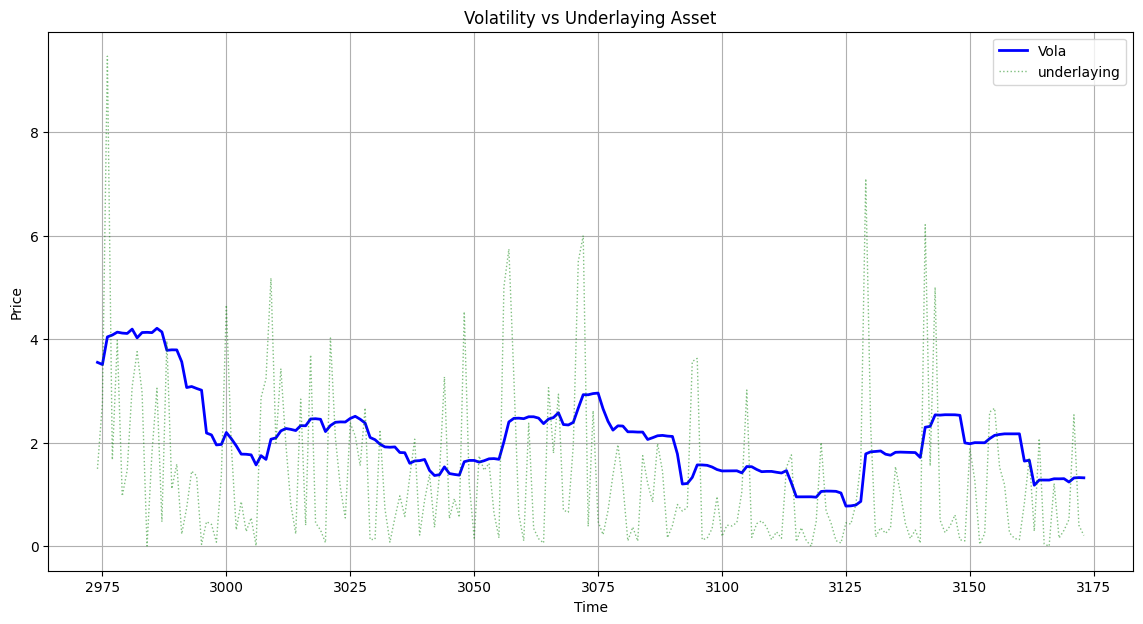

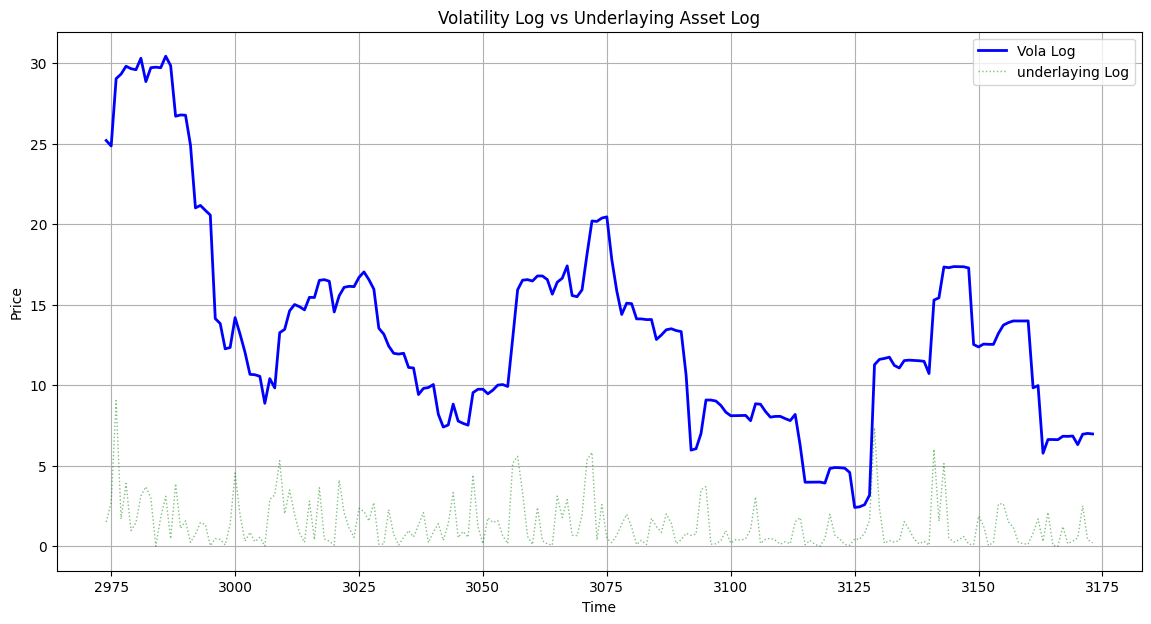

In [95]:
underlaying_log_full = data['Log_Returns'].copy().abs()
underlaying_log = underlaying_log_full[-200:]
#underlaying = data["Close"].copy()[-100:]
vola_log_full = data[f'Log_Returns_{VOLATILITY_WINDOW}_Volatility'].copy()
vola_log = vola_log_full[-200:]


underlaying = data["Close_Returns"].copy().abs()[-200:]
underlaying_full = data["Close_Returns"].copy()
vola_full = data[f'Close_Returns_{VOLATILITY_WINDOW}_Volatility'].copy()
vola = vola_full[-200:]

# scale the underlaying and log by 10 for better visualisation

underlaying = underlaying.apply(lambda x: SCALE_FACTOR*x)
underlaying_full = underlaying_full.apply(lambda x: SCALE_FACTOR*x)
underlaying_log = underlaying_log.apply(lambda x: SCALE_FACTOR*x)
underlaying_log_full = underlaying_log_full.apply(lambda x: SCALE_FACTOR*x)
vola = vola.apply(lambda x: SCALE_FACTOR*x)
vola_log = vola_log.apply(lambda x: SCALE_FACTOR*x)
vola_log_full = vola_log_full.apply(lambda x: SCALE_FACTOR*x)
vola_full = vola_full.apply(lambda x: SCALE_FACTOR*x)
# Visualise the data


visualisation.visualize_forcast(vola, base_assest=underlaying, label_forcast="Vola", label_base_asset="underlaying", title="Volatility vs Underlaying Asset")
visualisation.visualize_forcast(vola_log, base_assest=underlaying_log, label_forcast="Vola Log", label_base_asset="underlaying Log", title="Volatility Log vs Underlaying Asset Log")



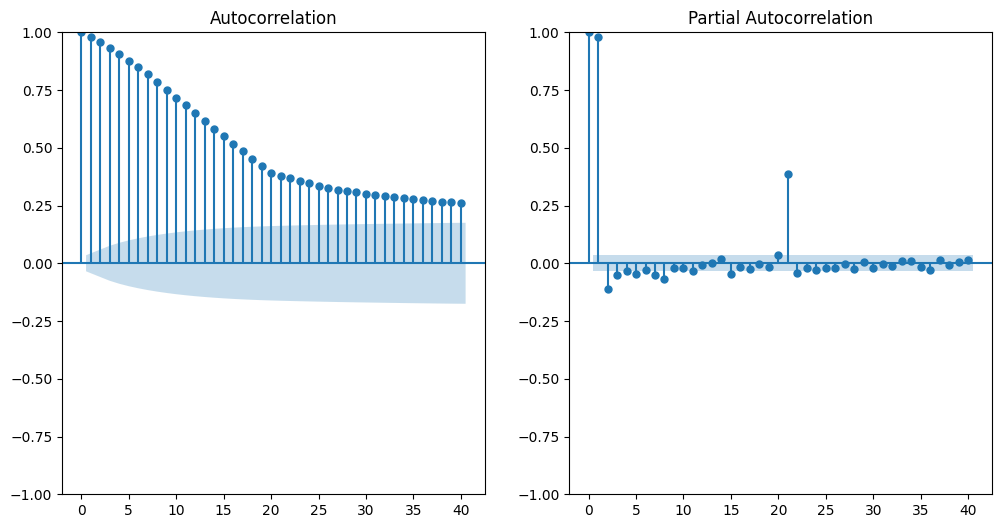

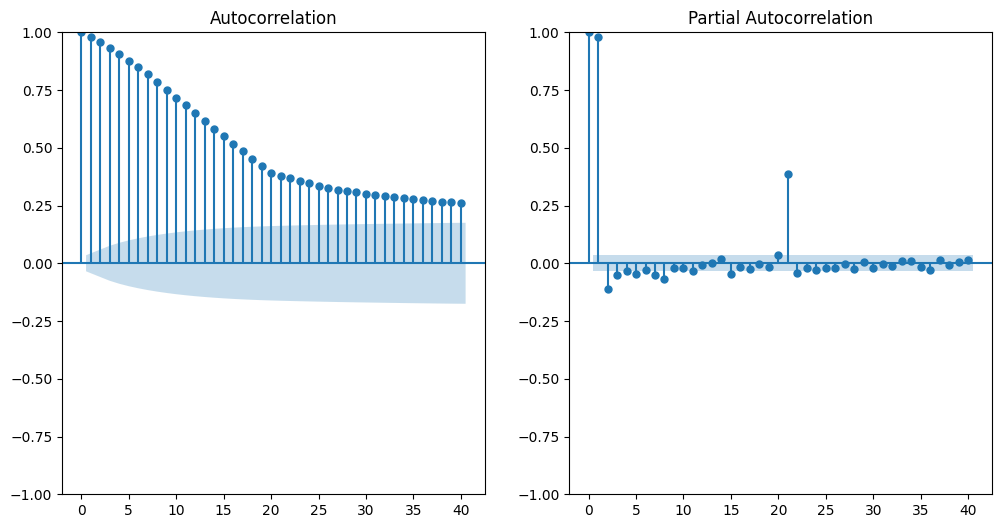

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Plot ACF and PACF of the residuals
residuals = garch_fit.resid
plt.figure(figsize=(12, 6))
plot_acf(vola_full, lags=40, ax=plt.subplot(121))
plot_pacf(vola_full, lags=40, ax=plt.subplot(122))

In [96]:
# Check if the time series is stationary using ADF and KPSS tests
def check_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c')
    print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
    print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")
    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
check_stationarity(underlaying_full)

ADF Statistic: -57.52932261975389, p-value: 0.0
KPSS Statistic: 0.2941196706091465, p-value: 0.1
The series is stationary.


/var/folders/k2/txrs3kj16m3bkd90r_g83kj00000gn/T/ipykernel_41673/1476903911.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


In [97]:
X_train, X_test = train_test_split(underlaying_full, test_size=FORECAST_TIMESERIES_LENGTH, random_state=42, shuffle=False)
print(X_train.shape, X_test.shape)


(2874,) (300,)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Close_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7706.36
Distribution:                  Normal   AIC:                           15420.7
Method:            Maximum Likelihood   BIC:                           15444.6
                                        No. Observations:                 2874
Date:                Fri, Jun 06 2025   Df Residuals:                     2873
Time:                        14:51:19   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2204  5.982e-02      3.684  2.298e-04 [  0.103,  0.33

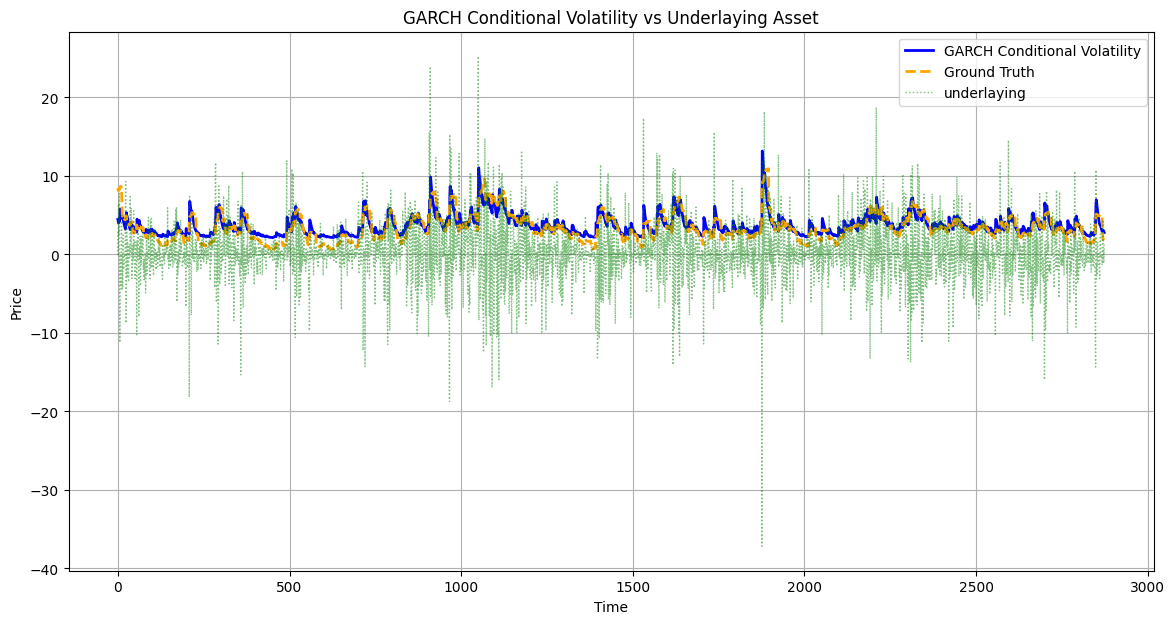

In [98]:
# train the GARCH(1, 1) model
garch = arch_model(X_train, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
garch_fit = garch.fit(disp="off")
conditional_volatility = garch_fit.conditional_volatility
vola_log_full_without_test = vola_full[:-X_test.shape[0]]
print(garch_fit.summary())

forcast = garch_fit.forecast(horizon=FORECAST_TIMESERIES_LENGTH, reindex=False)
forcast_vola_viz = pd.Series(np.reshape(forcast.variance, (FORECAST_TIMESERIES_LENGTH,))).apply(lambda x: np.sqrt(x))

X_test_viz = X_test.reset_index(drop=True)
test_vola_viz = vola_log_full[-X_test.shape[0]:].reset_index(drop=True)




# Visualise the GARCH model forecast
# visualize the conditional volatility
visualisation.visualize_forcast(conditional_volatility, base_assest=X_train, ground_trouth=vola_log_full_without_test, label_forcast="GARCH Conditional Volatility", label_base_asset="underlaying", title="GARCH Conditional Volatility vs Underlaying Asset")




In [99]:
def build_forcast_for_TIMESERIES_LENGTH(train, test, garch) -> pd.Series:
    """ Build a garch forcast model and forcasts one step ahead,
    then appends the forcast to the train set and repeats the process until the test set is reached.
    """
    test = test.copy()
    test = test.reset_index(drop=True)
    forcast = []
    for i in range(len(test)):
        garch_fit = garch.fit(disp="off")
        forcast_step = garch_fit.forecast(horizon=1, reindex=False)
        forcast_step_vola = np.sqrt(forcast_step.variance.iloc[-1, :])
        forcast.append(forcast_step_vola.iloc[0]) # this is safe to do because we only forecast one step ahead
        temp_series = pd.Series([test.iloc[i]], index=[train.shape[0] + i])
        train = pd.concat([train, temp_series], axis=0)
        garch = arch_model(train, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
    return pd.Series(forcast)

GARCH Model MSE: 0.014370946482742758, MAE: 0.10656976351660935


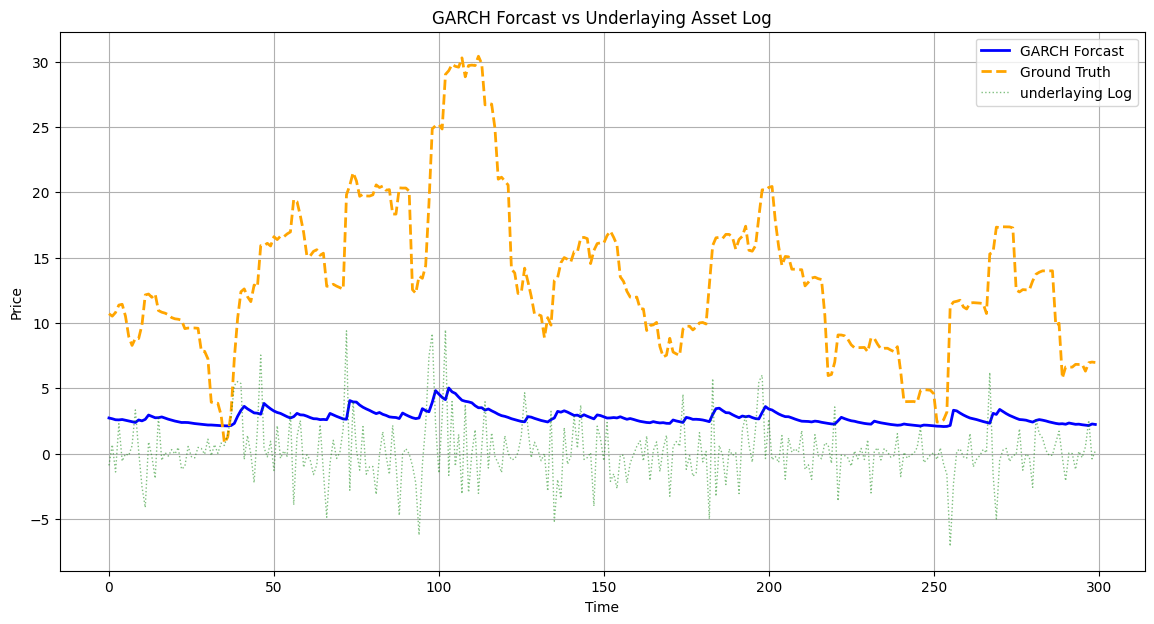

In [100]:

garch = arch_model(X_train, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
forcast_vola = build_forcast_for_TIMESERIES_LENGTH(X_train, X_test, garch)
# We will rescale the metrics to accuratly compare them with the LSTM model on their metrics. The Scale is now the original scale of the volatility.
forcast_vola_rescaled = forcast_vola.apply(lambda x: x/ SCALE_FACTOR)
test_vola_viz_rescaled = test_vola_viz.apply(lambda x: x/ SCALE_FACTOR)
# calculate MSE and MAE for the GARCH model
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(test_vola_viz_rescaled, forcast_vola_rescaled)
mae = mean_absolute_error(test_vola_viz_rescaled, forcast_vola_rescaled)
print(f"GARCH Model MSE: {mse}, MAE: {mae}")

# Visualise the GARCH model forecast
visualisation.visualize_forcast(forcast_vola, base_assest=X_test_viz, ground_trouth=test_vola_viz, label_forcast="GARCH Forcast", label_base_asset="underlaying Log", title="GARCH Forcast vs Underlaying Asset Log")

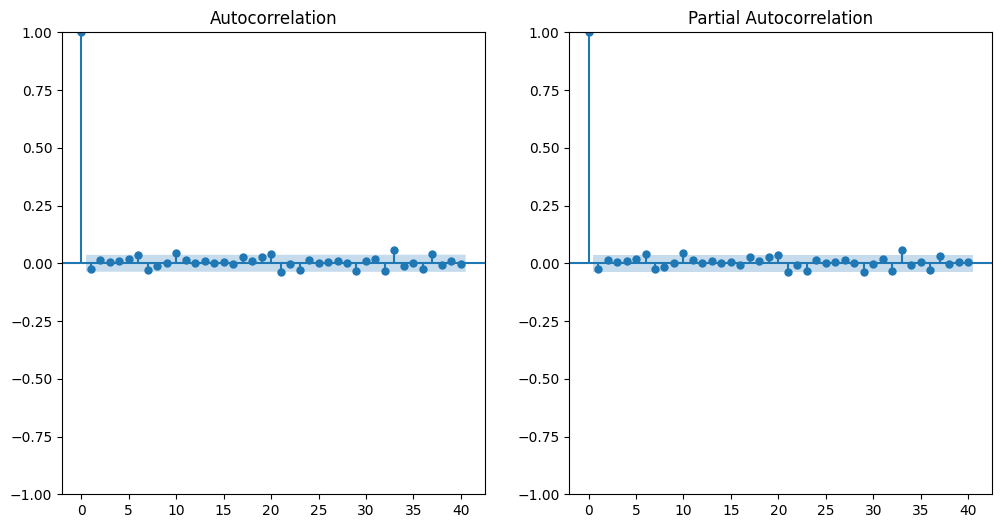

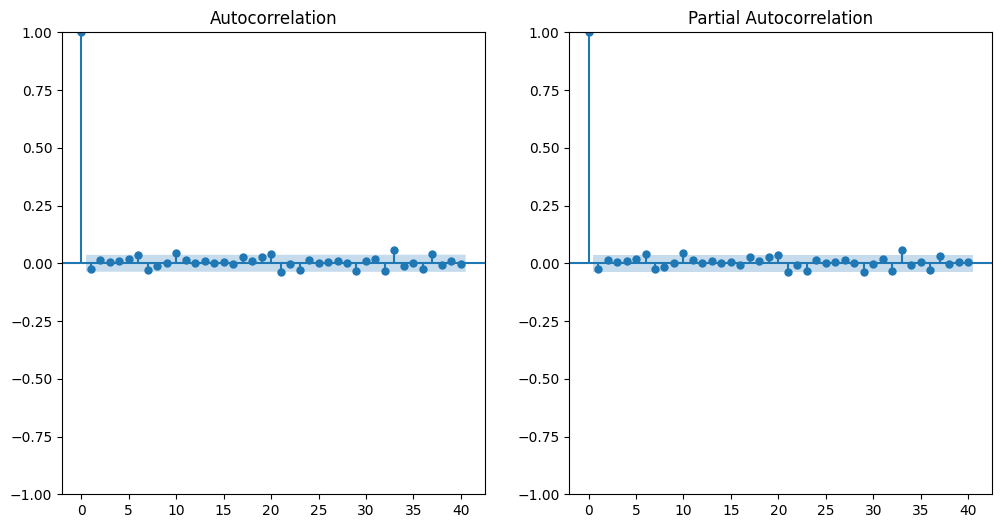

In [101]:
# Lets impove the GARCH model by using detrmining the ACF and PACF of the residuals
